# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [26]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from image_loader import LoadImage
from image_generator import create_datagen, create_generator
from callbacks_training_CNN import create_reduce_lr_callback, create_early_stopping_callback, train_model
from metrics_CNN import plot_training_history, plot_confusion_matrix
from extract_features import extract_features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

ImportError: cannot import name 'plot_confusion_matrix' from 'metrics_CNN' (/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py)

In [3]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [4]:
#Create a generator to preprocessing images using the class ImageDataGenerator
train_datagen = create_datagen(
    rotation_range=10, #rotating images 10º
    width_shift_range=0.1, #traslating images 10%
    height_shift_range=0.1, #traslating images 10%
    zoom_range=0.1, #10% zoom
    horizontal_flip=True) 

val_datagen = create_datagen()

test_datagen = ImageDataGenerator()

In [5]:
#Load and preprocessing images
train_generator = create_generator(train_datagen, train_dir)
#train_labels = train_generator.classes
val_generator = create_generator(val_datagen, val_dir, shuffle=False)
#val_labels = val_generator.classes
test_generator = create_generator(test_datagen, test_dir, shuffle=False)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


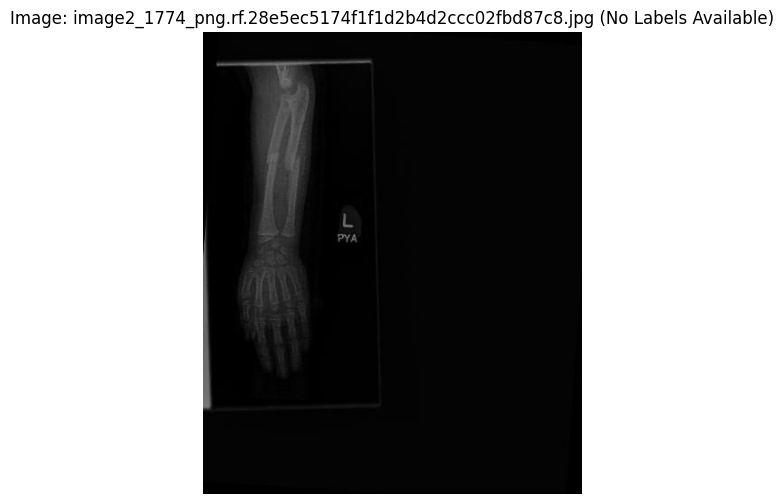

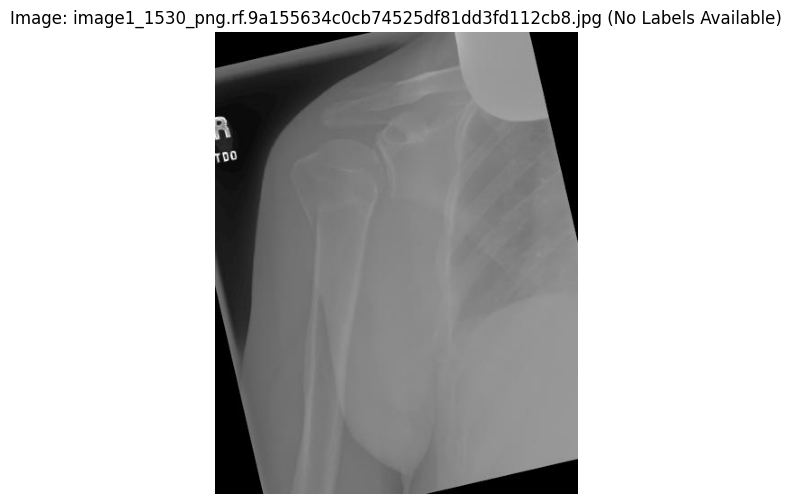

In [21]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----

### **Contruct a CNN**

### *Model 1*

In [6]:
#Construct the model 
model_CNN1 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN1.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN1.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN1.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN1.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN1.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN1.add(layers.Dense(1, activation='sigmoid'))

model_CNN1.summary()

I0000 00:00:1732622882.718931 1405253 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

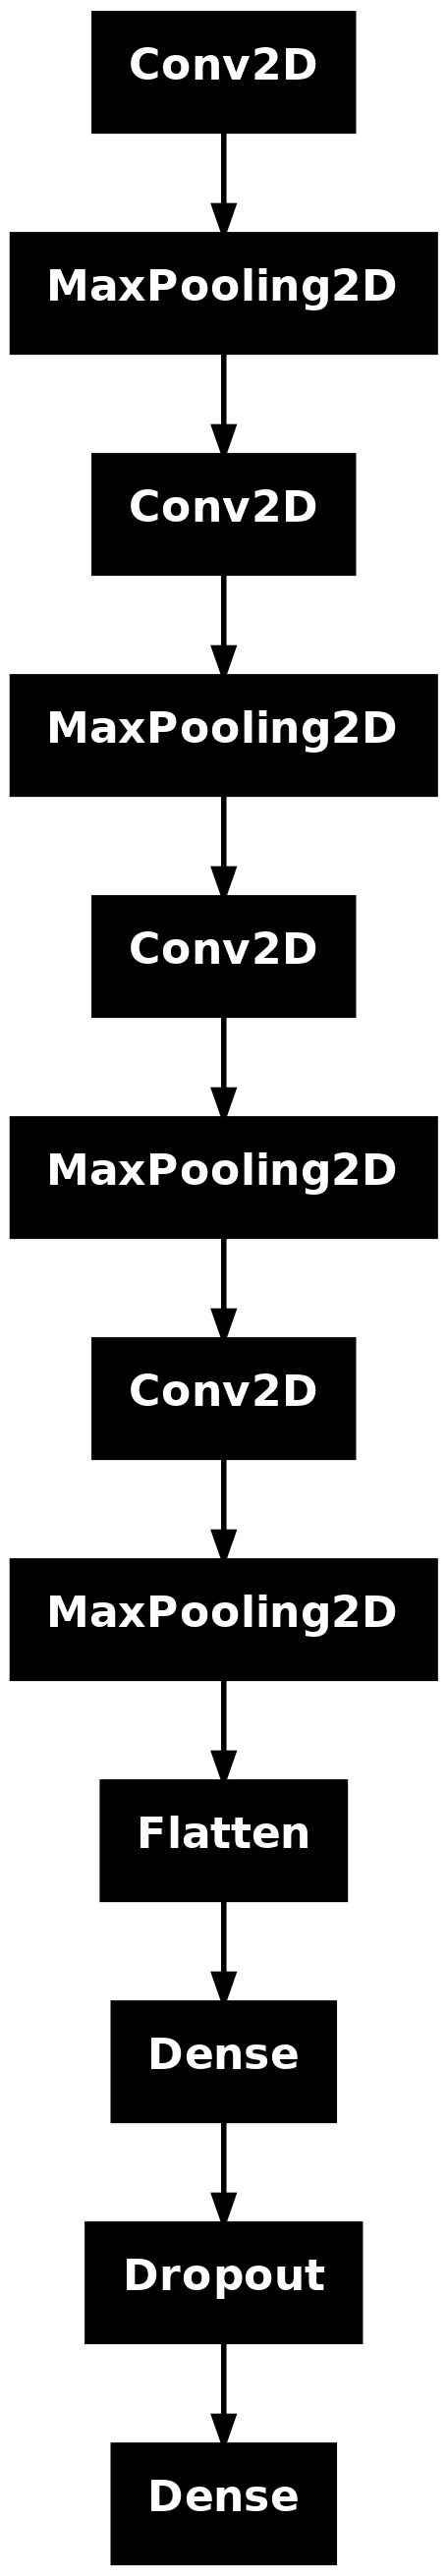

In [6]:
tf.keras.utils.plot_model(model_CNN1)

In [7]:
model_CNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [ ]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback()

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback()

#Train the model 
history = train_model(model_CNN1, train_generator, validation_data = val_generator, callbacks=[reduce_lr, early_stopping])

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1732622891.174332 1407046 service.cc:148] XLA service 0x7f082c00c850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732622891.174353 1407046 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-26 13:08:11.213801: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732622891.416258 1407046 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-26 13:08:11.783223: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"

  2/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5500 - loss: 0.89170

I0000 00:00:1732622895.377511 1407046 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5846 - loss: 0.7101

2024-11-26 13:08:45.639559: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-26 13:08:45.698970: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 222ms/step - accuracy: 0.5847 - loss: 0.7099 - val_accuracy: 0.4943 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.6487 - loss: 0.6638

2024-11-26 13:08:49.509404: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-26 13:08:49.509434: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-26 13:08:49.509444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 13:08:49.509455: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6772 - loss: 0.6636 - val_accuracy: 0.4959 - val_loss: 0.7484 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.6025 - loss: 0.6744 - val_accuracy: 0.4959 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.6415 - loss: 0.6428

2024-11-26 13:09:21.914779: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6019 - loss: 0.6659 - val_accuracy: 0.4959 - val_loss: 0.7068 - learning_rate: 0.0010


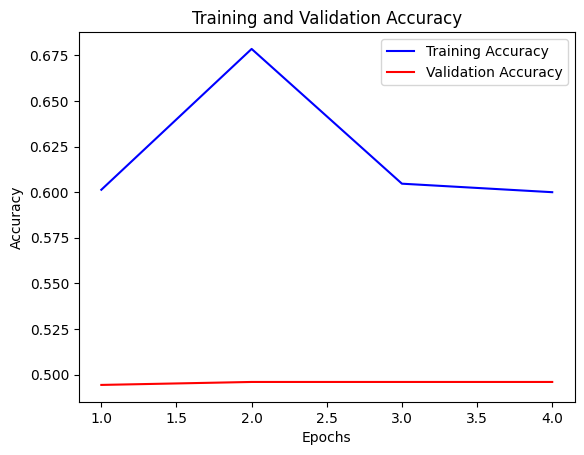

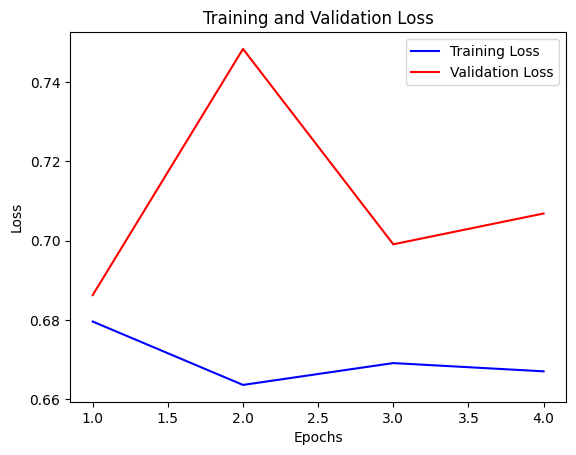

In [9]:
plot_training_history(history)

------

In [17]:
#Same model but patient 10 instead of 3

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_CNN1, train_generator, epochs = 100, validation_data = val_generator, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7477 - loss: 0.5174 - val_accuracy: 0.7154 - val_loss: 0.5785 - learning_rate: 5.0000e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7066 - loss: 0.5279 - val_accuracy: 0.7138 - val_loss: 0.5845 - learning_rate: 5.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 203ms/step - accuracy: 0.7481 - loss: 0.5028 - val_accuracy: 0.7008 - val_loss: 0.6051 - learning_rate: 5.0000e-05
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.7631 - loss: 0.4781

2024-11-26 15:03:32.399130: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:03:32.399159: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7506 - loss: 0.4846 - val_accuracy: 0.7154 - val_loss: 0.5765 - learning_rate: 5.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7606 - loss: 0.5044 - val_accuracy: 0.7171 - val_loss: 0.5641 - learning_rate: 5.0000e-05
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.7552 - loss: 0.4805

2024-11-26 15:04:05.226963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7434 - loss: 0.5036 - val_accuracy: 0.7252 - val_loss: 0.5625 - learning_rate: 5.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.7632 - loss: 0.4943 - val_accuracy: 0.7350 - val_loss: 0.5719 - learning_rate: 5.0000e-05
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7495 - loss: 0.4433 - val_accuracy: 0.7382 - val_loss: 0.5722 - learning_rate: 5.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.7530 - loss: 0.5090 - val_accuracy: 0.7268 - val_loss: 0.5511 - learning_rate: 5.0000e-05
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.8378 - loss: 0.4108

2024-11-26 15:05:11.276280: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:05:11.276307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8086 - loss: 0.4185 - val_accuracy: 0.7431 - val_loss: 0.5612 - learning_rate: 5.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.7539 - loss: 0.4933 - val_accuracy: 0.7317 - val_loss: 0.5771 - learning_rate: 5.0000e-05
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7775 - loss: 0.5100 - val_accuracy: 0.7333 - val_loss: 0.5580 - learning_rate: 5.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.7511 - loss: 0.5005 - val_accuracy: 0.7512 - val_loss: 0.5509 - learning_rate: 5.0000e-05
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7330 - loss: 0.5121 - val_accuracy: 0.7317 - val_loss: 0.5455 - learning_rate: 5.0000e-05
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7472 - loss: 0.5026 - val_accuracy: 0.7268 - val_loss: 0.5751 - learning_rate: 5.0000e-05
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/ste

2024-11-26 15:07:23.840659: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:07:23.840688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7413 - loss: 0.5436 - val_accuracy: 0.7463 - val_loss: 0.5596 - learning_rate: 5.0000e-05
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.7511 - loss: 0.5055 - val_accuracy: 0.7301 - val_loss: 0.5434 - learning_rate: 5.0000e-05
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.7792 - loss: 0.4936

2024-11-26 15:07:56.273926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:07:56.273961: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7446 - loss: 0.5406 - val_accuracy: 0.7317 - val_loss: 0.5447 - learning_rate: 5.0000e-05
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.7520 - loss: 0.4904 - val_accuracy: 0.7415 - val_loss: 0.5565 - learning_rate: 5.0000e-05
Epoch 22/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.7372 - loss: 0.4813

2024-11-26 15:08:28.768910: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:08:28.768941: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7698 - loss: 0.4578 - val_accuracy: 0.7398 - val_loss: 0.5741 - learning_rate: 5.0000e-05
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.7595 - loss: 0.4845 - val_accuracy: 0.7301 - val_loss: 0.5433 - learning_rate: 5.0000e-05
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.7755 - loss: 0.4334

2024-11-26 15:09:01.419123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:09:01.419156: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7784 - loss: 0.4520 - val_accuracy: 0.7252 - val_loss: 0.5379 - learning_rate: 5.0000e-05
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.7345 - loss: 0.5185 - val_accuracy: 0.7415 - val_loss: 0.5431 - learning_rate: 5.0000e-05
Epoch 26/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8274 - loss: 0.4490 - val_accuracy: 0.7350 - val_loss: 0.5607 - learning_rate: 5.0000e-05
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.7632 - loss: 0.4812 - val_accuracy: 0.7366 - val_loss: 0.5544 - learning_rate: 5.0000e-05
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8065 - loss: 0.4437 - val_accuracy: 0.7431 - val_loss: 0.5406 - learning_rate: 5.0000e-05
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.7490 - loss: 0.4893 - val_accuracy: 0.7415 - val_loss: 0.5837 - learning_rate: 5.0000e-05
Epoch 30/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/s

2024-11-26 15:10:39.531115: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7449 - loss: 0.5387 - val_accuracy: 0.7350 - val_loss: 0.6017 - learning_rate: 5.0000e-05
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.7515 - loss: 0.4919 - val_accuracy: 0.7350 - val_loss: 0.5681 - learning_rate: 5.0000e-05
Epoch 32/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7884 - loss: 0.4526 - val_accuracy: 0.7301 - val_loss: 0.5920 - learning_rate: 5.0000e-05
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.7714 - loss: 0.4820 - val_accuracy: 0.7415 - val_loss: 0.5653 - learning_rate: 5.0000e-05
Epoch 34/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.7443 - loss: 0.5013

2024-11-26 15:11:45.562120: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12627120411710681439
2024-11-26 15:11:45.562151: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4645274100429648800


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7361 - loss: 0.4928 - val_accuracy: 0.7496 - val_loss: 0.5578 - learning_rate: 5.0000e-05


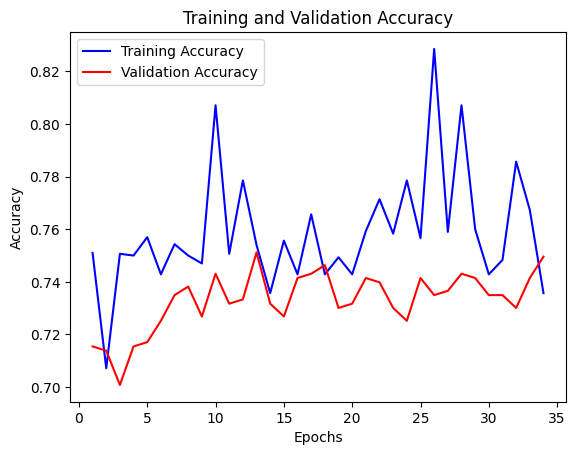

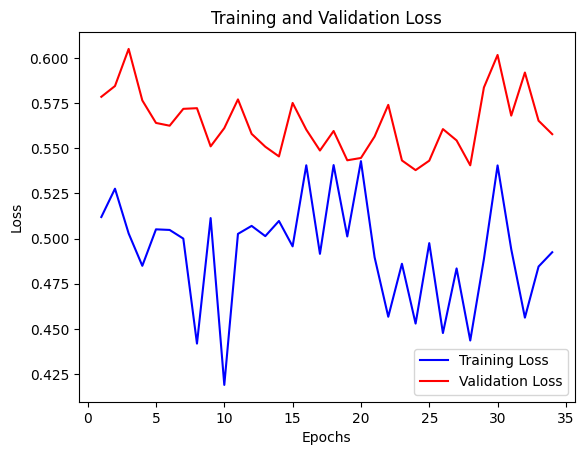

In [18]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Accuracy in test dataset: 0.4954367666232073
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       380
           1       0.00      0.00      0.00       387

    accuracy                           0.50       767
   macro avg       0.25      0.50      0.33       767
weighted avg       0.25      0.50      0.33       767



/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

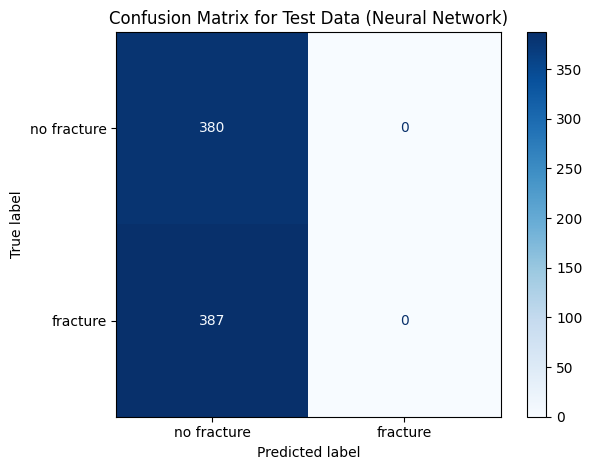

In [ ]:
#F-score and confusion matrix
accurary, class_report, cm = plot

----

In [12]:
optimizer = Adam(learning_rate=1e-4)
model_CNN1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [13]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = model_CNN1.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
 24/150 ━━━━━━━━━━━━━━━━━━━━ 23s 188ms/step - accuracy: 0.5909 - loss: 0.6721

KeyboardInterrupt: 

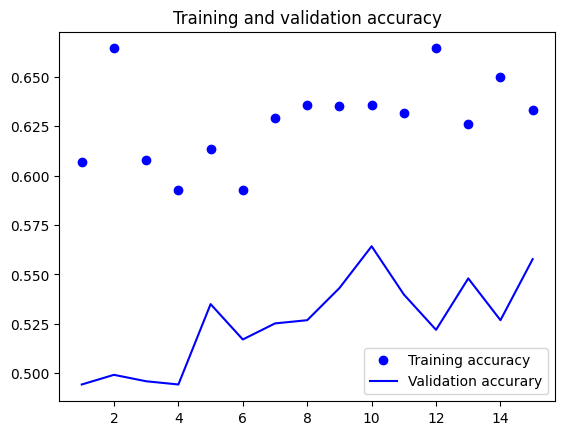

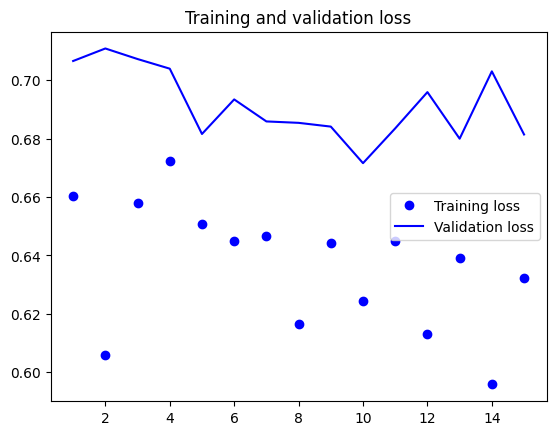

In [30]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

------------

### *Model 2*

In [31]:
#Construct the model 
model_CNN2 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN2.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Dropout(0.3)) #add a dropout
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN2.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN2.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN2.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

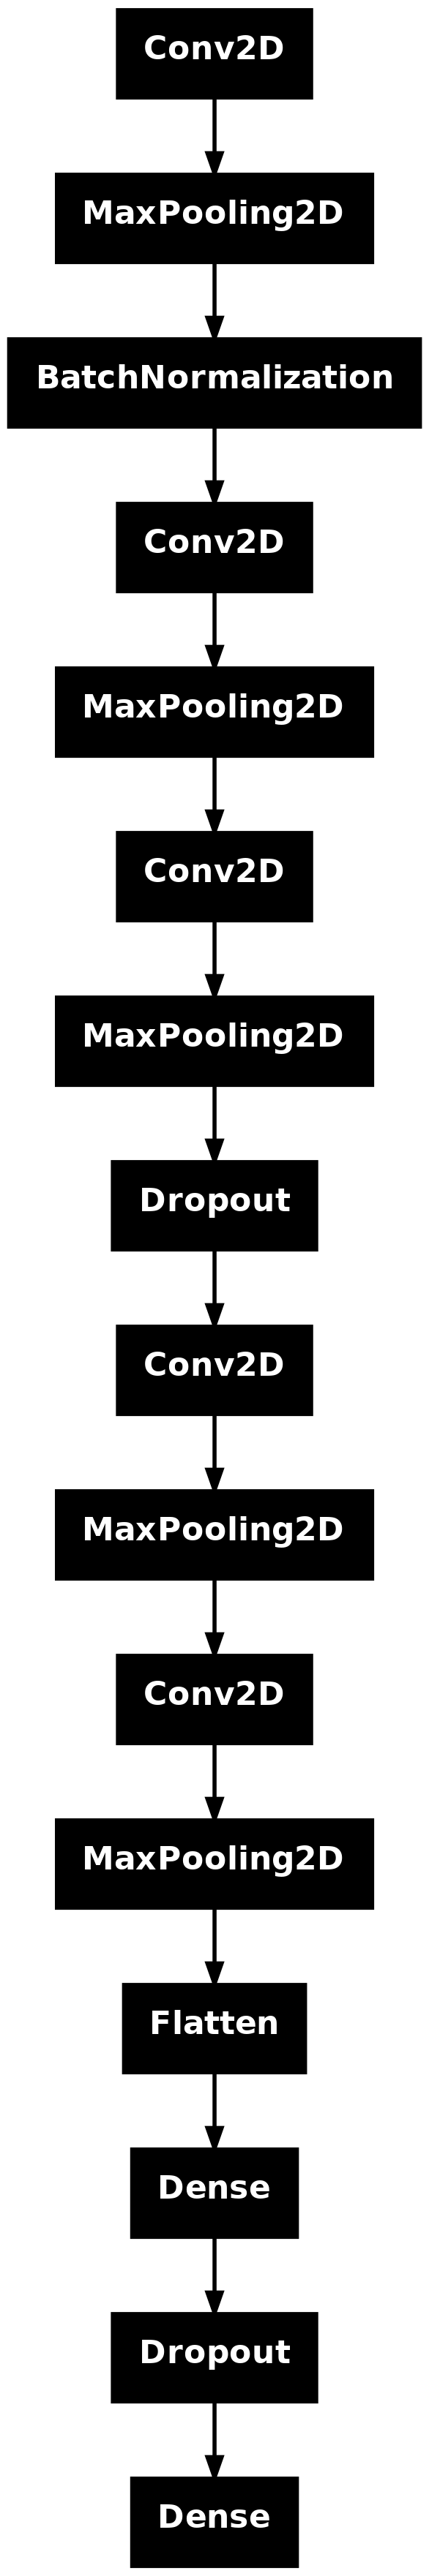

In [35]:
tf.keras.utils.plot_model(model_CNN2)

In [32]:
optimizer = Adam(learning_rate=1e-3)
model_CNN2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = model_CNN2.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100


2024-11-22 11:32:05.700913: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5935 - loss: 0.8027

2024-11-22 11:32:38.032992: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-22 11:32:39.222117: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,256,12,12]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", bac

150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 213ms/step - accuracy: 0.5935 - loss: 0.8020 - val_accuracy: 0.4959 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.6135 - loss: 0.6501

2024-11-22 11:32:40.650296: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 11:32:40.650337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6142 - loss: 0.6560 - val_accuracy: 0.4959 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.6056 - loss: 0.6692 - val_accuracy: 0.4959 - val_loss: 0.6976 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5715 - loss: 0.6785 - val_accuracy: 0.4959 - val_loss: 0.6980 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 209ms/step - accuracy: 0.6167 - loss: 0.6652 - val_accuracy: 0.4959 - val_loss: 0.6973 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5797 - loss: 0.6942 - val_accuracy: 0.4959 - val_loss: 0.6985 - learning_rate: 0.0010


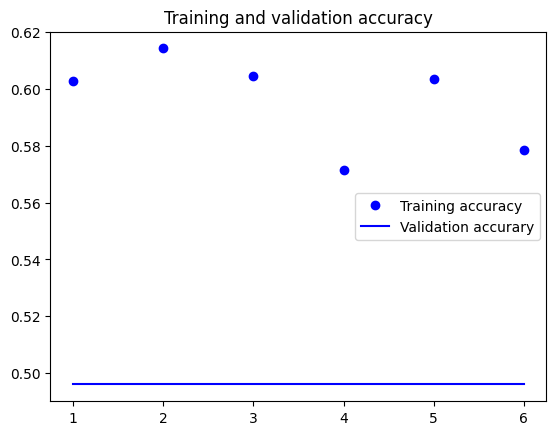

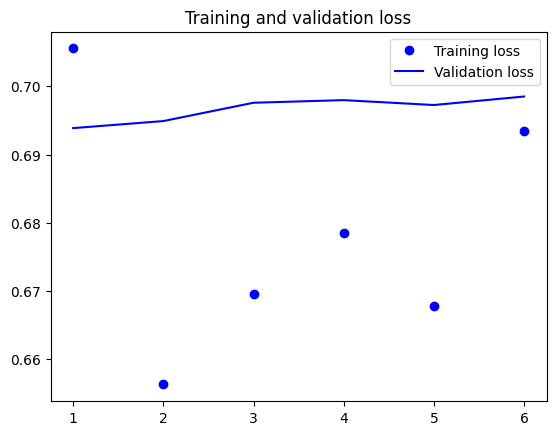

In [34]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

---------

### *Model 3*

In [35]:
#Construct the model 
model_CNN3 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN3.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L2 regularization
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Dropout(0.4)) #add a dropout
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN3.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN3.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

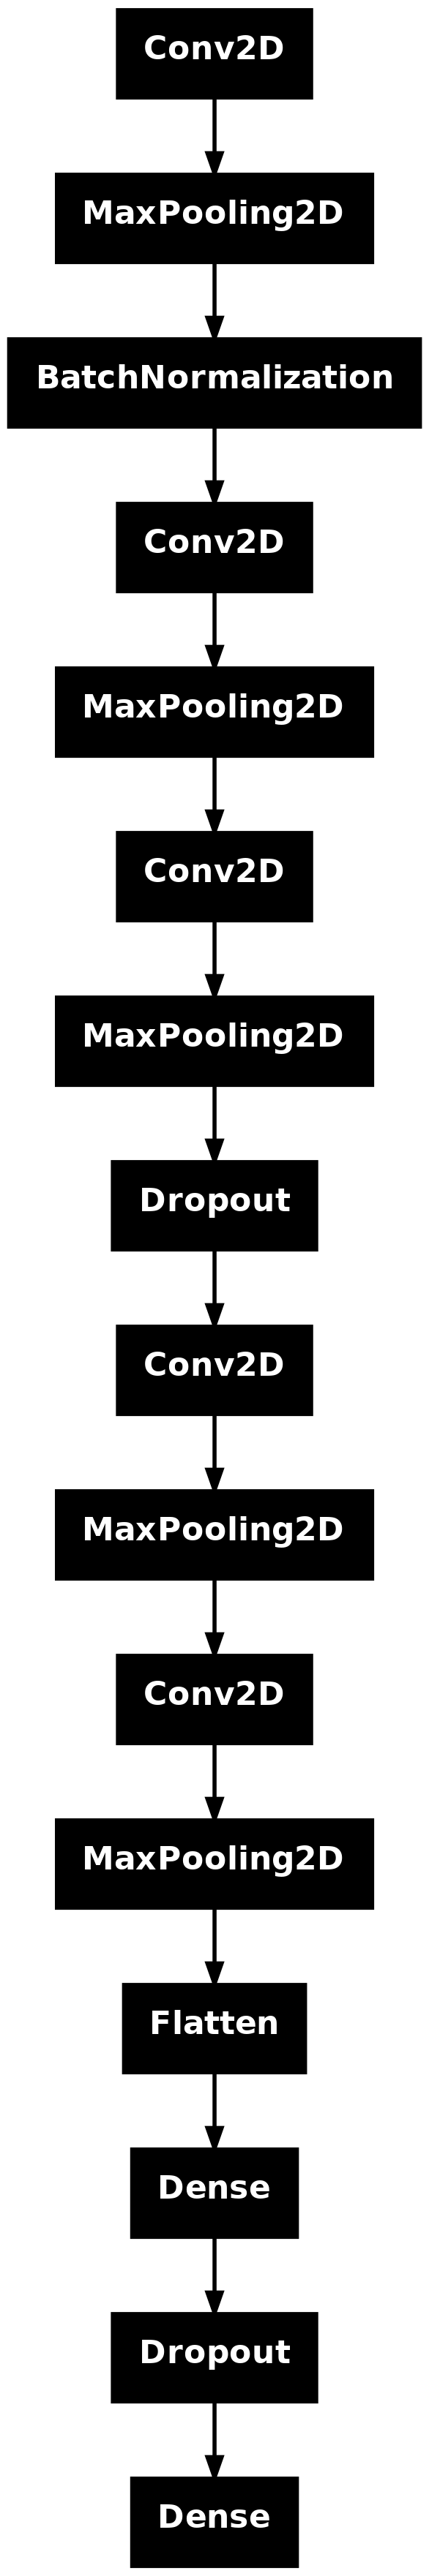

In [40]:
tf.keras.utils.plot_model(model_CNN3)

In [36]:
optimizer = Adam(learning_rate=1e-3)
model_CNN3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = model_CNN3.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 215ms/step - accuracy: 0.5881 - loss: 7.5012 - val_accuracy: 0.4959 - val_loss: 1.4613 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6070 - loss: 1.4157 - val_accuracy: 0.4959 - val_loss: 1.4016 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.5975 - loss: 1.1755 - val_accuracy: 0.4959 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6157 - loss: 0.8375 - val_accuracy: 0.4959 - val_loss: 0.8760 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.6031 - loss: 0.8012 - val_accuracy: 0.4959 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6061 - loss: 0.7327 - val_accuracy: 0.4959 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.

2024-11-22 11:51:55.085235: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 11:51:55.085273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6762 - loss: 0.6539 - val_accuracy: 0.4959 - val_loss: 0.7351 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.6135 - loss: 0.6813 - val_accuracy: 0.4959 - val_loss: 0.7221 - learning_rate: 0.0010
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.6457 - loss: 0.6666

2024-11-22 11:52:27.504972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 11:52:27.505001: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6702 - loss: 0.6559 - val_accuracy: 0.4959 - val_loss: 0.7241 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6028 - loss: 0.6787 - val_accuracy: 0.4959 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5925 - loss: 0.6830 - val_accuracy: 0.4959 - val_loss: 0.7198 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.6098 - loss: 0.6742 - val_accuracy: 0.4959 - val_loss: 0.7178 - learning_rate: 0.0010
Epoch 16/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6070 - loss: 0.6737 - val_accuracy: 0.4959 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6033 - loss: 0.6742 - val_accuracy: 0.4959 - val_loss: 0.7168 - learning_rate: 0.0010
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.6401 -

2024-11-22 11:54:06.344367: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 11:54:06.344401: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6223 - loss: 0.6639 - val_accuracy: 0.4959 - val_loss: 0.7179 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 207ms/step - accuracy: 0.6021 - loss: 0.6735 - val_accuracy: 0.4959 - val_loss: 0.7190 - learning_rate: 0.0010
Epoch 20/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5868 - loss: 0.6804 - val_accuracy: 0.4959 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step - accuracy: 0.6056 - loss: 0.6716 - val_accuracy: 0.4959 - val_loss: 0.7169 - learning_rate: 0.0010
Epoch 22/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6147 - loss: 0.6693 - val_accuracy: 0.4959 - val_loss: 0.7176 - learning_rate: 0.0010


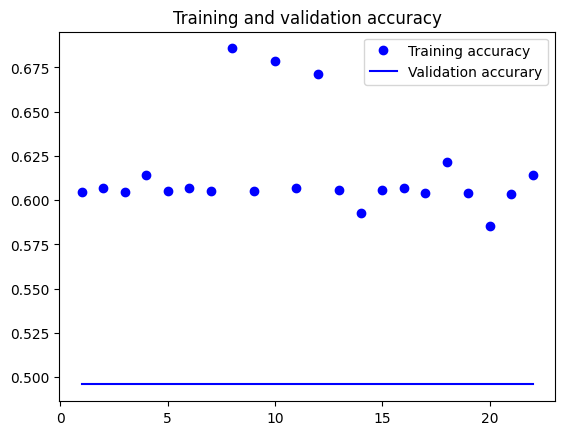

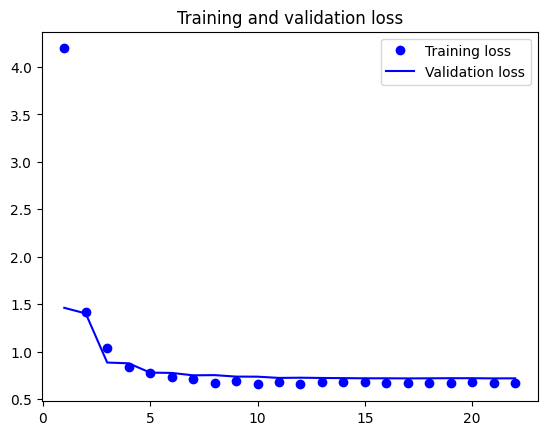

In [38]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

------------

### **Pretrained network VGG16**

In [39]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

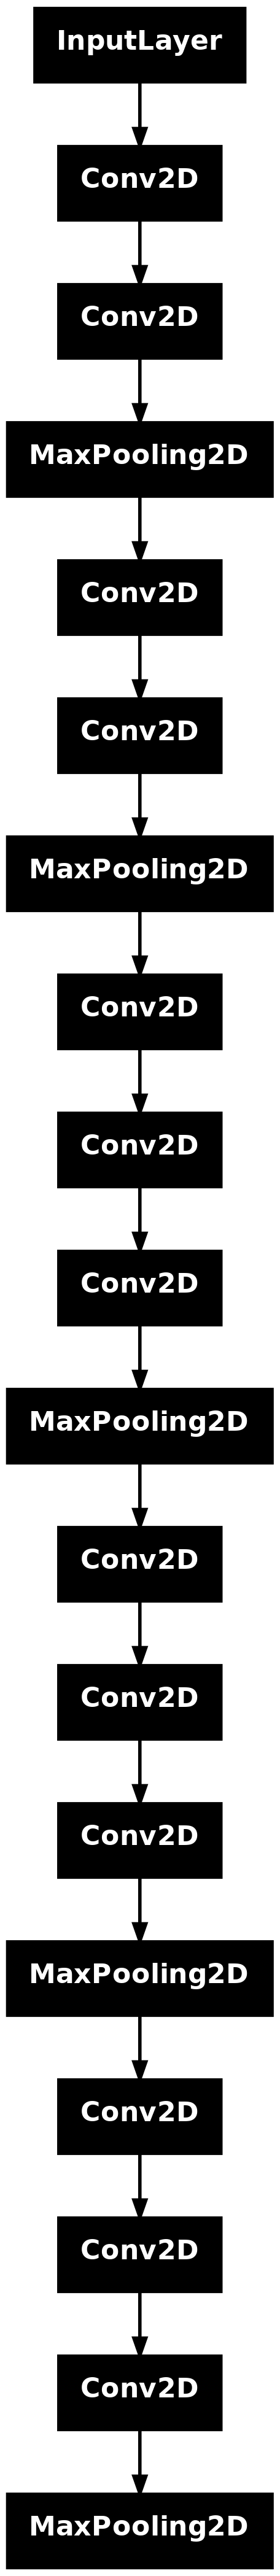

In [19]:
tf.keras.utils.plot_model(conv_base_VGG16)

### *Loading and preprocessing images*

In [41]:
#Loading and preprocessing images

#Creating a generator to preprocessing images using the class ImageDataGenerator
train_datagen = create_datagen(
    rotation_range=10, #rotating images 10º
    width_shift_range=0.1, #traslating images 10%
    height_shift_range=0.1, #traslating images 10%
    zoom_range=0.1, #10% zoom
    horizontal_flip=True) 

val_datagen = create_datagen()

test_datagen = ImageDataGenerator()


train_generator = create_generator(train_datagen, train_dir, target_size = (224, 224))
train_labels = train_generator.classes
val_generator = create_generator(val_datagen, val_dir, target_size = (224, 224), shuffle = False)
val_labels = val_generator.classes
test_generator = create_generator(test_datagen, test_dir, target_size = (224, 224), shuffle = False)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


### *Fine-tunning*

**Model 1**

In [42]:
model_VGG16_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_1.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_1.add(layers.Flatten())  # Flatten extracted features
model_VGG16_1.add(layers.Dense(256, activation='relu'))  # Full-connected layer
model_VGG16_1.add(layers.Dropout(0.5))  #To avoid over-fitting
model_VGG16_1.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

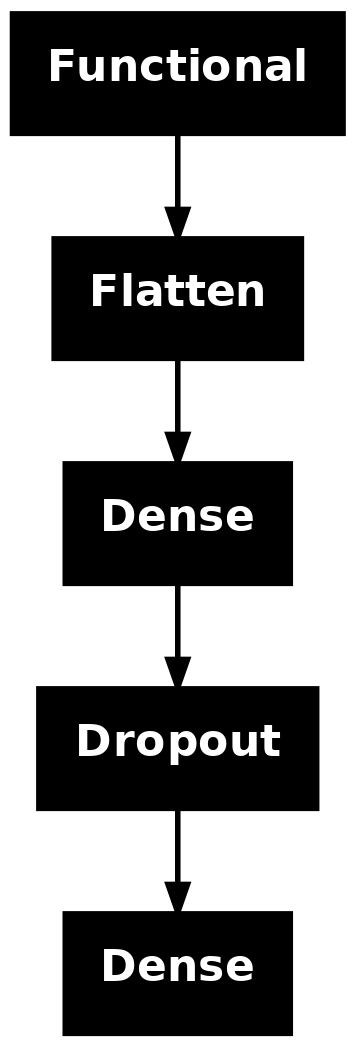

In [6]:
tf.keras.utils.plot_model(model_VGG16_1)

In [43]:
model_VGG16_1.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = model_VGG16_1.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.7206 - loss: 0.4906 - val_accuracy: 0.7236 - val_loss: 0.5561 - learning_rate: 2.5000e-04
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.7619 - loss: 0.4569

2024-11-22 12:47:33.502587: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:47:33.502621: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7506 - loss: 0.4694 - val_accuracy: 0.7317 - val_loss: 0.5420 - learning_rate: 2.5000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.7173 - loss: 0.4975 - val_accuracy: 0.7415 - val_loss: 0.5330 - learning_rate: 2.5000e-04
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7361 - loss: 0.5348 - val_accuracy: 0.7480 - val_loss: 0.5228 - learning_rate: 2.5000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.6927 - loss: 0.5126 - val_accuracy: 0.7333 - val_loss: 0.5307 - learning_rate: 2.5000e-04
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.8088 - loss: 0.4269

2024-11-22 12:48:38.144222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:48:38.144252: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8004 - loss: 0.4284 - val_accuracy: 0.7512 - val_loss: 0.5227 - learning_rate: 2.5000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.7363 - loss: 0.4796 - val_accuracy: 0.7561 - val_loss: 0.5364 - learning_rate: 2.5000e-04
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.8230 - loss: 0.4196

2024-11-22 12:49:10.280108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:49:10.280142: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8079 - loss: 0.4289 - val_accuracy: 0.7593 - val_loss: 0.5374 - learning_rate: 2.5000e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.7365 - loss: 0.4871 - val_accuracy: 0.7545 - val_loss: 0.5079 - learning_rate: 2.5000e-04
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.7986 - loss: 0.4233

2024-11-22 12:49:42.327077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:49:42.327109: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7863 - loss: 0.4417 - val_accuracy: 0.7528 - val_loss: 0.5285 - learning_rate: 2.5000e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.7580 - loss: 0.4608 - val_accuracy: 0.7675 - val_loss: 0.5061 - learning_rate: 2.5000e-04
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.7277 - loss: 0.4268

2024-11-22 12:50:14.586386: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7285 - loss: 0.4376 - val_accuracy: 0.7740 - val_loss: 0.5002 - learning_rate: 2.5000e-04
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.7326 - loss: 0.4968 - val_accuracy: 0.7593 - val_loss: 0.5184 - learning_rate: 2.5000e-04
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7014 - loss: 0.5167 - val_accuracy: 0.7707 - val_loss: 0.4931 - learning_rate: 2.5000e-04
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.7573 - loss: 0.4623 - val_accuracy: 0.7610 - val_loss: 0.5036 - learning_rate: 2.5000e-04
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - accuracy: 0.6638 - loss: 0.4483

2024-11-22 12:51:19.645459: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-22 12:51:19.645488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:51:19.645503: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6643 - loss: 0.4721 - val_accuracy: 0.7610 - val_loss: 0.5142 - learning_rate: 2.5000e-04
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.7675 - loss: 0.4676 - val_accuracy: 0.7561 - val_loss: 0.5104 - learning_rate: 2.5000e-04
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.8045 - loss: 0.4205

2024-11-22 12:51:52.029454: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:51:52.029486: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8002 - loss: 0.4297 - val_accuracy: 0.7366 - val_loss: 0.5421 - learning_rate: 2.5000e-04
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.7602 - loss: 0.4682 - val_accuracy: 0.7561 - val_loss: 0.5217 - learning_rate: 2.5000e-04
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.7745 - loss: 0.4581

2024-11-22 12:52:24.505065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:52:24.505097: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7580 - loss: 0.4774 - val_accuracy: 0.7642 - val_loss: 0.5111 - learning_rate: 2.5000e-04
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.7672 - loss: 0.4616 - val_accuracy: 0.7220 - val_loss: 0.5905 - learning_rate: 2.5000e-04
Epoch 22/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.8038 - loss: 0.4298

2024-11-22 12:52:57.070051: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:52:57.070083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8070 - loss: 0.4277 - val_accuracy: 0.7382 - val_loss: 0.5723 - learning_rate: 2.5000e-04
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.7574 - loss: 0.4731 - val_accuracy: 0.7561 - val_loss: 0.5192 - learning_rate: 2.5000e-04
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.8198 - loss: 0.4252

2024-11-22 12:53:29.637874: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 12:53:29.637913: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8009 - loss: 0.4551 - val_accuracy: 0.7691 - val_loss: 0.4941 - learning_rate: 2.5000e-04


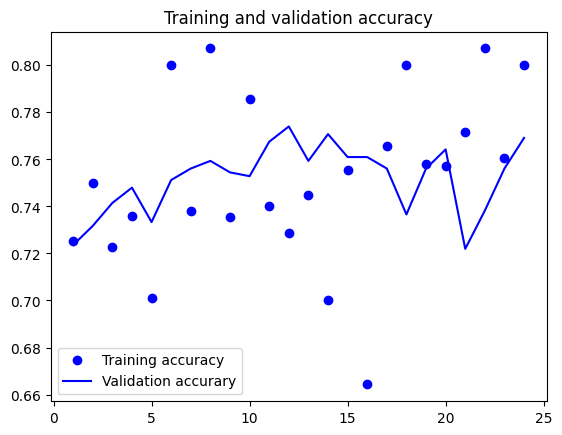

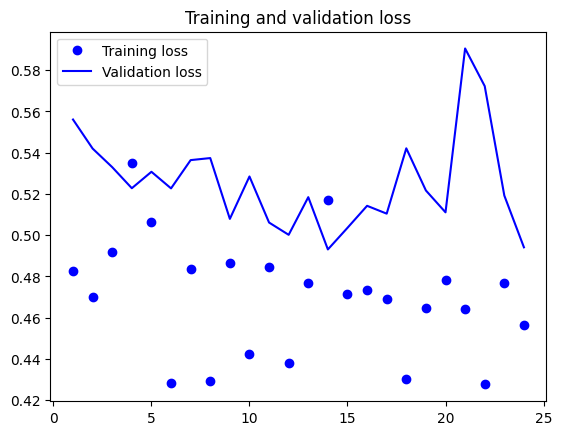

In [50]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

**Model 2**

In [51]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [52]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

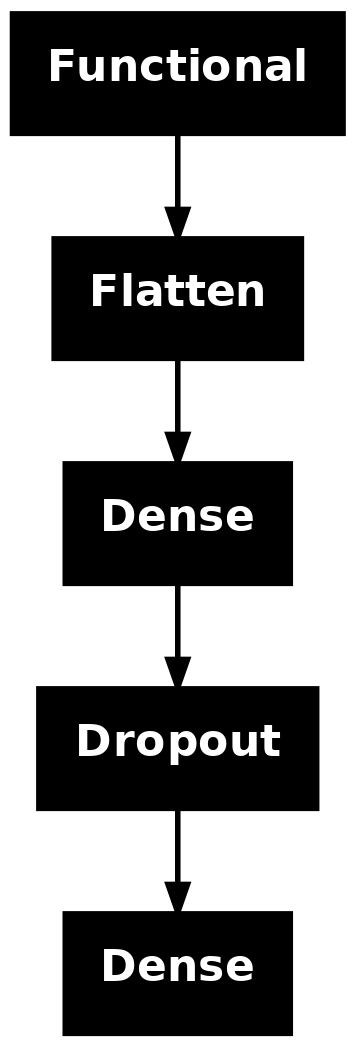

In [26]:
tf.keras.utils.plot_model(model_VGG16_2)

In [53]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = model_VGG16_2.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

Epoch 1/100


2024-11-22 13:01:48.182139: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-22 13:01:48.588915: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 254ms/step - accuracy: 0.5679 - loss: 5.5207 - val_accuracy: 0.5447 - val_loss: 4.8034 - learning_rate: 1.0000e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6079 - loss: 4.7840 - val_accuracy: 0.5772 - val_loss: 4.7454 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.6513 - loss: 4.5194 - val_accuracy: 0.6894 - val_loss: 3.9859 - learning_rate: 1.0000e-05
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6979 - loss: 3.9761 - val_accuracy: 0.7154 - val_loss: 3.9308 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.7498 - loss: 3.7603 - val_accuracy: 0.7024 - val_loss: 3.4571 - learning_rate: 1.0000e-05
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7142 - loss: 3.4250 - val_accuracy: 0.7691 - val_loss: 3.3603 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - 

2024-11-22 13:04:43.901297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489
2024-11-22 13:04:43.901433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7641 - loss: 2.9871 - val_accuracy: 0.7431 - val_loss: 2.9936 - learning_rate: 1.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 255ms/step - accuracy: 0.7997 - loss: 2.8479 - val_accuracy: 0.7902 - val_loss: 2.6265 - learning_rate: 1.0000e-05
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8351 - loss: 2.6330 - val_accuracy: 0.7902 - val_loss: 2.6396 - learning_rate: 1.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - accuracy: 0.8251 - loss: 2.5233 - val_accuracy: 0.8276 - val_loss: 2.3877 - learning_rate: 1.0000e-05
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7976 - loss: 2.3815 - val_accuracy: 0.7610 - val_loss: 2.4748 - learning_rate: 1.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 250ms/step - accuracy: 0.8492 - loss: 2.2746 - val_accuracy: 0.8000 - val_loss: 2.2136 - learning_rate: 1.0000e-05
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step

2024-11-22 13:14:09.741022: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1742153531679336430


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9219 - loss: 1.1927 - val_accuracy: 0.8520 - val_loss: 1.4038 - learning_rate: 1.0000e-05


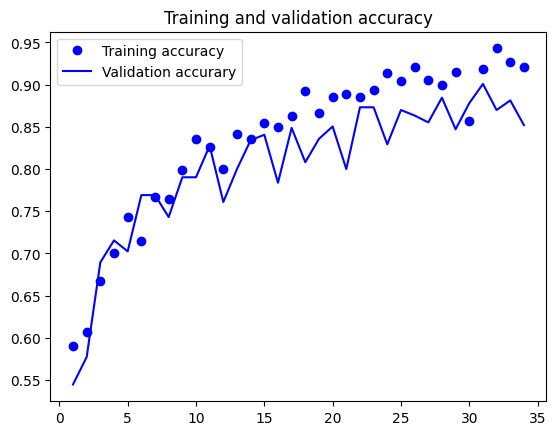

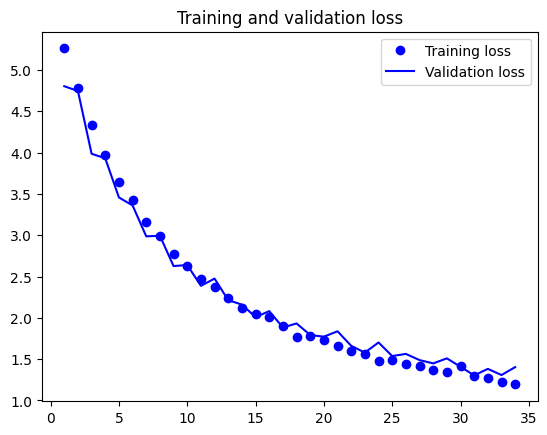

In [55]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step
Accuracy en validación: 0.5040650406504065
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       310
           1       0.00      0.00      0.00       305

    accuracy                           0.50       615
   macro avg       0.25      0.50      0.34       615
weighted avg       0.25      0.50      0.34       615



/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

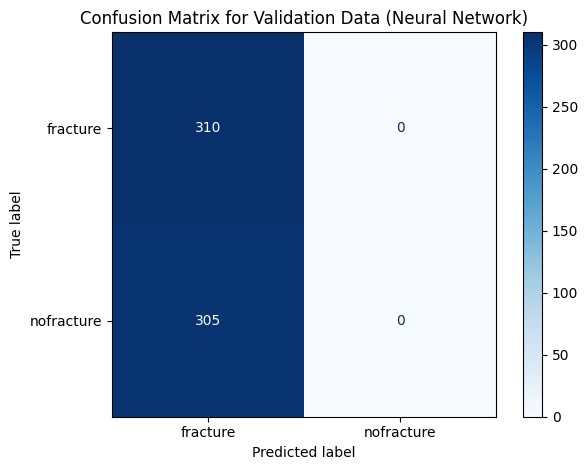

In [56]:
#caluating the model with validation dataset

#Get predictions for the validation dataset
val_predictions = model_VGG16_2.predict(val_generator, steps=len(val_generator), verbose=1)
#Convert the predicted probabilities to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)
#Get the true labels from the validation generator
val_true_labels = val_generator.classes
#Calculate and print accuracy
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print("Accuracy en validación:", accuracy)
#Print classification report
class_report = classification_report(val_true_labels, val_pred_labels)
print(class_report)
#Compute the confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Data (Neural Network)')
plt.tight_layout()
plt.show()

**Model 2.1**

In [27]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = model_VGG16_2.fit(
    train_generator,
    steps_per_epoch = 150, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 195ms/step - accuracy: 0.5672 - loss: 5.5210 - val_accuracy: 0.5041 - val_loss: 4.8907 - learning_rate: 1.0000e-05
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.6898 - loss: 4.8271

2024-11-20 13:06:32.357232: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-20 13:06:32.357258: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-20 13:06:32.357325: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6723 - loss: 4.8079 - val_accuracy: 0.4976 - val_loss: 4.8913 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.6205 - loss: 4.6034 - val_accuracy: 0.4959 - val_loss: 4.2689 - learning_rate: 1.0000e-05
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.6879 - loss: 4.0886

2024-11-20 13:07:04.575821: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6722 - loss: 4.0738 - val_accuracy: 0.5024 - val_loss: 4.1669 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.6460 - loss: 3.9150 - val_accuracy: 0.5772 - val_loss: 3.5447 - learning_rate: 1.0000e-05
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.6486 - loss: 3.4909

2024-11-20 13:07:36.793353: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:07:36.793390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6567 - loss: 3.4638 - val_accuracy: 0.5545 - val_loss: 3.5348 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.6446 - loss: 3.3618 - val_accuracy: 0.6553 - val_loss: 3.0533 - learning_rate: 1.0000e-05
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.6418 - loss: 3.0275

2024-11-20 13:08:08.966923: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-20 13:08:08.966949: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:08:08.966963: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6292 - loss: 3.0490 - val_accuracy: 0.6244 - val_loss: 3.0521 - learning_rate: 1.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.6724 - loss: 2.9289 - val_accuracy: 0.6407 - val_loss: 2.7126 - learning_rate: 1.0000e-05
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.6738 - loss: 2.6411

2024-11-20 13:08:41.156414: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:08:41.156444: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7124 - loss: 2.6164 - val_accuracy: 0.6358 - val_loss: 2.6944 - learning_rate: 1.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.6716 - loss: 2.5836 - val_accuracy: 0.6374 - val_loss: 2.4220 - learning_rate: 1.0000e-05
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.7155 - loss: 2.3801

2024-11-20 13:09:13.367160: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6939 - loss: 2.4000 - val_accuracy: 0.6407 - val_loss: 2.4099 - learning_rate: 1.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.6883 - loss: 2.3056 - val_accuracy: 0.6715 - val_loss: 2.1797 - learning_rate: 1.0000e-05
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7144 - loss: 2.1226 - val_accuracy: 0.6537 - val_loss: 2.1770 - learning_rate: 1.0000e-05
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.7029 - loss: 2.0908 - val_accuracy: 0.6846 - val_loss: 1.9902 - learning_rate: 1.0000e-05
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - accuracy: 0.6906 - loss: 1.9627

2024-11-20 13:10:17.861681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-20 13:10:17.861706: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:10:17.861718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6859 - loss: 1.9602 - val_accuracy: 0.5984 - val_loss: 2.0474 - learning_rate: 1.0000e-05
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.6969 - loss: 1.9284 - val_accuracy: 0.6016 - val_loss: 1.9158 - learning_rate: 1.0000e-05
Epoch 18/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6489 - loss: 1.8588 - val_accuracy: 0.6325 - val_loss: 1.8824 - learning_rate: 1.0000e-05
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 185ms/step - accuracy: 0.7168 - loss: 1.7841 - val_accuracy: 0.6976 - val_loss: 1.7375 - learning_rate: 1.0000e-05
Epoch 20/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.7689 - loss: 1.6478

2024-11-20 13:11:22.814613: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:11:22.814646: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7713 - loss: 1.6454 - val_accuracy: 0.6634 - val_loss: 1.7522 - learning_rate: 1.0000e-05
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.6947 - loss: 1.6883 - val_accuracy: 0.6585 - val_loss: 1.6775 - learning_rate: 1.0000e-05
Epoch 22/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.7203 - loss: 1.6398

2024-11-20 13:11:55.229447: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:11:55.229476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7282 - loss: 1.6344 - val_accuracy: 0.6211 - val_loss: 1.7021 - learning_rate: 1.0000e-05
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.7129 - loss: 1.6060 - val_accuracy: 0.6894 - val_loss: 1.5666 - learning_rate: 1.0000e-05
Epoch 24/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7233 - loss: 1.5322

2024-11-20 13:12:27.387430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:12:27.387460: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7079 - loss: 1.5470 - val_accuracy: 0.6976 - val_loss: 1.5683 - learning_rate: 1.0000e-05
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.7192 - loss: 1.5226 - val_accuracy: 0.7041 - val_loss: 1.5146 - learning_rate: 1.0000e-05
Epoch 26/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.7400 - loss: 1.4790

2024-11-20 13:12:59.324203: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:12:59.324232: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7359 - loss: 1.4726 - val_accuracy: 0.7073 - val_loss: 1.5093 - learning_rate: 1.0000e-05
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.7114 - loss: 1.4772 - val_accuracy: 0.6829 - val_loss: 1.4754 - learning_rate: 1.0000e-05
Epoch 28/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.6854 - loss: 1.4661

2024-11-20 13:13:31.401758: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:13:31.401786: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6925 - loss: 1.4580 - val_accuracy: 0.6959 - val_loss: 1.4464 - learning_rate: 1.0000e-05
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.7243 - loss: 1.4098 - val_accuracy: 0.6520 - val_loss: 1.4654 - learning_rate: 1.0000e-05
Epoch 30/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.6659 - loss: 1.3815

2024-11-20 13:14:03.280261: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6913 - loss: 1.3959 - val_accuracy: 0.6163 - val_loss: 1.5119 - learning_rate: 1.0000e-05
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.7226 - loss: 1.3818 - val_accuracy: 0.6976 - val_loss: 1.3724 - learning_rate: 1.0000e-05
Epoch 32/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.6838 - loss: 1.4073

2024-11-20 13:14:35.277164: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-20 13:14:35.277190: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:14:35.277201: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7265 - loss: 1.3519 - val_accuracy: 0.6667 - val_loss: 1.4139 - learning_rate: 1.0000e-05
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.7353 - loss: 1.3267 - val_accuracy: 0.6959 - val_loss: 1.3395 - learning_rate: 1.0000e-05
Epoch 34/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.7198 - loss: 1.3025

2024-11-20 13:15:07.536436: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:15:07.536477: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7554 - loss: 1.2911 - val_accuracy: 0.6992 - val_loss: 1.3480 - learning_rate: 1.0000e-05
Epoch 35/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.7331 - loss: 1.2929 - val_accuracy: 0.7171 - val_loss: 1.3009 - learning_rate: 1.0000e-05
Epoch 36/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7992 - loss: 1.2171 - val_accuracy: 0.7089 - val_loss: 1.3060 - learning_rate: 1.0000e-05
Epoch 37/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.7335 - loss: 1.2669 - val_accuracy: 0.7138 - val_loss: 1.2790 - learning_rate: 1.0000e-05
Epoch 38/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.7464 - loss: 1.2517

2024-11-20 13:16:12.808307: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1103284141662225019
2024-11-20 13:16:12.808335: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7738131806678925778


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7090 - loss: 1.2615 - val_accuracy: 0.7154 - val_loss: 1.2676 - learning_rate: 1.0000e-05
Epoch 39/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.7503 - loss: 1.2381 - val_accuracy: 0.6894 - val_loss: 1.2741 - learning_rate: 1.0000e-05
Epoch 40/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6992 - loss: 1.2308 - val_accuracy: 0.6797 - val_loss: 1.2848 - learning_rate: 1.0000e-05
Epoch 41/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.7456 - loss: 1.2136 - val_accuracy: 0.6667 - val_loss: 1.2779 - learning_rate: 1.0000e-05


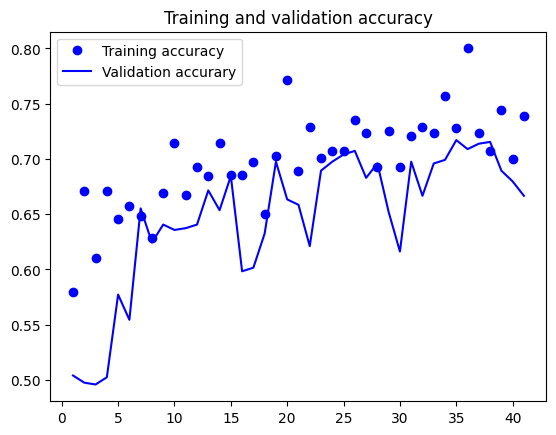

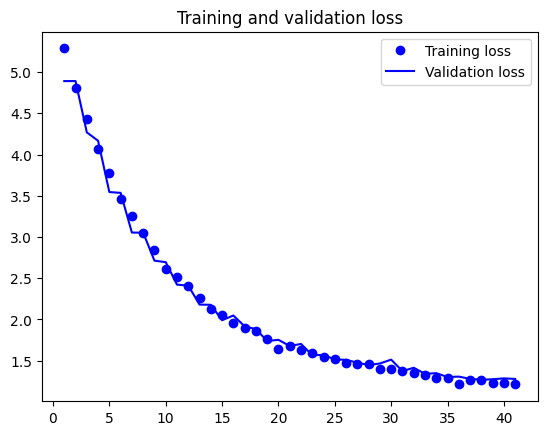

In [31]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step
Accuracy en validación: 0.5040650406504065
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       310
           1       0.00      0.00      0.00       305

    accuracy                           0.50       615
   macro avg       0.25      0.50      0.34       615
weighted avg       0.25      0.50      0.34       615



/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

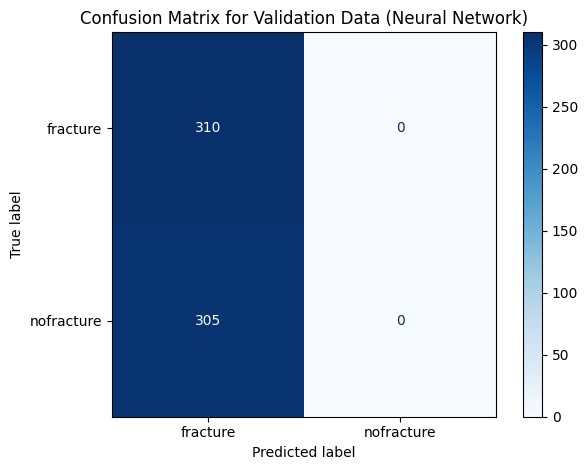

In [32]:
#caluating the model with validation dataset

#Get predictions for the validation dataset
val_predictions = model_VGG16_2.predict(val_generator, steps=len(val_generator), verbose=1)
#Convert the predicted probabilities to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)
#Get the true labels from the validation generator
val_true_labels = val_generator.classes
#Calculate and print accuracy
accuracy = accuracy_score(val_true_labels, val_pred_labels)
print("Accuracy en validación:", accuracy)
#Print classification report
class_report = classification_report(val_true_labels, val_pred_labels)
print(class_report)
#Compute the confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Data (Neural Network)')
plt.tight_layout()
plt.show()

### *Transfer learning*

**Model 3**

In [8]:
#Extract features
train_features, train_labels = extract_features(train_generator, conv_base_VGG16)
val_features, val_labels = extract_features(val_generator, conv_base_VGG16)
test_features, test_labels = extract_features(test_generator, conv_base_VGG16)

I0000 00:00:1732103018.698968  622901 service.cc:148] XLA service 0x7ff554003160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732103018.698990  622901 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-11-20 12:43:38.706512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732103018.754536  622901 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-20 12:43:39.024479: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1732103024.928933  622901 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

2024-11-20 12:44:39.662787: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 12:44:39.729996: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

2024-11-20 12:44:51.756916: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 12:44:51.838730: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [9]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [15]:
#Training the Machine Learning Model

#Random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

Accuracy en validación: 0.6016260162601627
              precision    recall  f1-score   support

         0.0       0.83      0.26      0.40       310
         1.0       0.56      0.94      0.70       305

    accuracy                           0.60       615
   macro avg       0.69      0.60      0.55       615
weighted avg       0.69      0.60      0.55       615



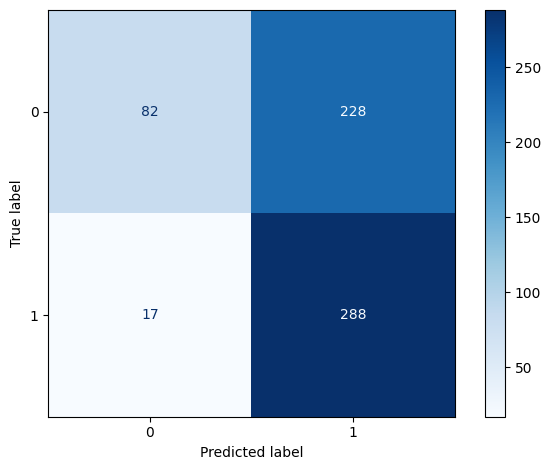

In [26]:
#Evaluating the model
val_predictions = random_forest.predict(val_features)
print("Accuracy en validación:", accuracy_score(val_labels, val_predictions))
print(classification_report(val_labels, val_predictions))

cm = confusion_matrix(val_labels, val_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

-----------------

### **Pretrained network ResNet-50**

In [5]:
#Load ResNet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
resnet_base.trainable = False

resnet_base.summary()

I0000 00:00:1732262629.591397 4072329 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

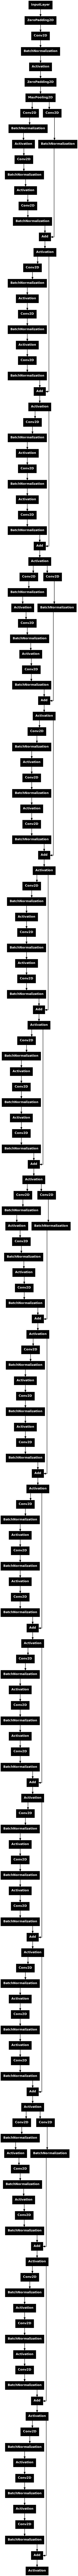

In [8]:
tf.keras.utils.plot_model(resnet_base)

### *Loading and preprocesing images*

In [15]:
#Loading and preprocessing images

#Creating a generator to preprocessing images using the class ImageDataGenerator
train_datagen = create_datagen(
    rotation_range=10, #rotating images 10º
    width_shift_range=0.1, #traslating images 10%
    height_shift_range=0.1, #traslating images 10%
    zoom_range=0.1, #10% zoom
    horizontal_flip=True) 

val_datagen = create_datagen()

test_datagen = ImageDataGenerator()


train_generator = create_generator(train_datagen, train_dir, target_size = (224, 224), batch_size= 32)
train_labels = train_generator.classes
val_generator = create_generator(val_datagen, val_dir, target_size = (224, 224), batch_size= 32, shuffle = False)
val_labels = val_generator.classes
test_generator = create_generator(test_datagen, test_dir, target_size = (224, 224), batch_size= 32, shuffle = False)

Found 3140 images belonging to 2 classes.
Found 615 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


### *Fine-tunning*

**Model 1**

In [10]:
model_resnet_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_1.add(resnet_base)

# Add personalized layers
model_resnet_1.add(layers.Flatten())  # Flatten extracted features
model_resnet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_1.add(layers.Dense(1, activation='sigmoid'))

model_resnet_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

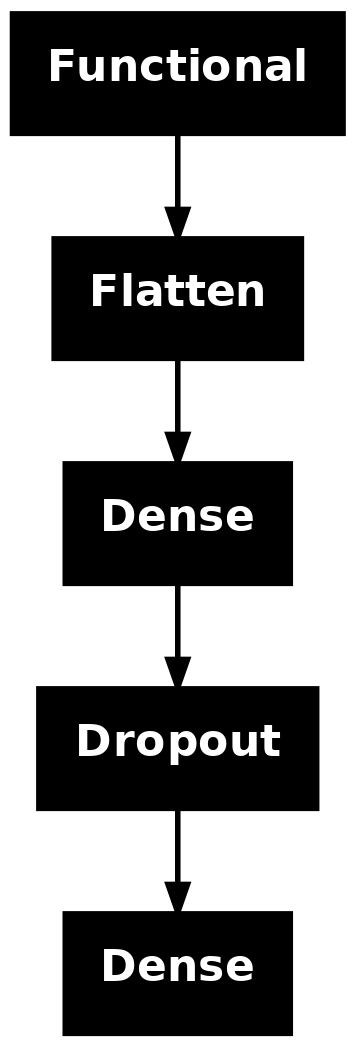

In [10]:
tf.keras.utils.plot_model(model_resnet_1)

In [11]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = model_resnet_1.fit(
    train_generator,
    steps_per_epoch = 130, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping]  
)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.5727 - loss: 3.5493

2024-11-22 10:03:41.385382: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-22 10:03:41.385464: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - accuracy: 0.5737 - loss: 3.4913 - val_accuracy: 0.5593 - val_loss: 2.8359 - learning_rate: 1.0000e-05
Epoch 2/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.5789 - loss: 2.6452

2024-11-22 10:04:12.099435: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 10:04:12.099479: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.5807 - loss: 2.6053 - val_accuracy: 0.4959 - val_loss: 2.1673 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5962 - loss: 1.9890 - val_accuracy: 0.4992 - val_loss: 1.7275 - learning_rate: 1.0000e-05
Epoch 4/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.5964 - loss: 1.5964

2024-11-22 10:05:05.041755: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 10:05:05.041782: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.5985 - loss: 1.5768 - val_accuracy: 0.4992 - val_loss: 1.4117 - learning_rate: 1.0000e-05
Epoch 5/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.6137 - loss: 1.3024

2024-11-22 10:05:31.247411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6103 - loss: 1.2921 - val_accuracy: 0.4959 - val_loss: 1.2675 - learning_rate: 1.0000e-05
Epoch 6/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.5996 - loss: 1.1250

2024-11-22 10:05:58.119002: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - accuracy: 0.5985 - loss: 1.1173 - val_accuracy: 0.4976 - val_loss: 1.0526 - learning_rate: 1.0000e-05
Epoch 7/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.5721 - loss: 1.0095

2024-11-22 10:06:24.799399: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 203ms/step - accuracy: 0.5774 - loss: 1.0029 - val_accuracy: 0.4959 - val_loss: 1.0696 - learning_rate: 1.0000e-05
Epoch 8/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 247ms/step - accuracy: 0.5950 - loss: 0.9234

2024-11-22 10:06:50.916402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 10:06:50.916435: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5941 - loss: 0.9215 - val_accuracy: 0.4976 - val_loss: 0.9348 - learning_rate: 1.0000e-05
Epoch 9/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: 0.6101 - loss: 0.8755

2024-11-22 10:07:18.078377: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.6083 - loss: 0.8742 - val_accuracy: 0.4927 - val_loss: 0.8797 - learning_rate: 1.0000e-05
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5928 - loss: 0.8517 - val_accuracy: 0.4992 - val_loss: 0.8668 - learning_rate: 1.0000e-05
Epoch 11/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.5928 - loss: 0.8315

2024-11-22 10:08:10.709108: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5952 - loss: 0.8301 - val_accuracy: 0.4992 - val_loss: 0.8827 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5884 - loss: 0.8220 - val_accuracy: 0.5008 - val_loss: 0.8379 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5885 - loss: 0.8068 - val_accuracy: 0.4992 - val_loss: 0.8628 - learning_rate: 1.0000e-05
Epoch 14/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.5952 - loss: 0.8008

2024-11-22 10:09:29.474826: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5962 - loss: 0.8002 - val_accuracy: 0.4992 - val_loss: 0.8787 - learning_rate: 1.0000e-05
Epoch 15/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.6004 - loss: 0.7925

2024-11-22 10:09:55.677309: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.6011 - loss: 0.7928 - val_accuracy: 0.4992 - val_loss: 0.8365 - learning_rate: 1.0000e-05
Epoch 16/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.6095 - loss: 0.7774

2024-11-22 10:10:21.870199: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6073 - loss: 0.7794 - val_accuracy: 0.4976 - val_loss: 0.8189 - learning_rate: 1.0000e-05
Epoch 17/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.6230 - loss: 0.7780

2024-11-22 10:10:48.406286: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.6199 - loss: 0.7793 - val_accuracy: 0.4992 - val_loss: 0.8432 - learning_rate: 1.0000e-05
Epoch 18/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.6014 - loss: 0.7849

2024-11-22 10:11:15.297400: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 206ms/step - accuracy: 0.6025 - loss: 0.7838 - val_accuracy: 0.5008 - val_loss: 0.8264 - learning_rate: 1.0000e-05
Epoch 19/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.5945 - loss: 0.7850

2024-11-22 10:11:41.294231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5954 - loss: 0.7841 - val_accuracy: 0.5008 - val_loss: 0.8090 - learning_rate: 1.0000e-05
Epoch 20/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6066 - loss: 0.7735 - val_accuracy: 0.4976 - val_loss: 0.8245 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.6013 - loss: 0.7730 - val_accuracy: 0.4992 - val_loss: 0.8245 - learning_rate: 1.0000e-05
Epoch 22/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.5963 - loss: 0.7692

2024-11-22 10:12:59.839450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8871430569903275489


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5992 - loss: 0.7680 - val_accuracy: 0.4992 - val_loss: 0.8158 - learning_rate: 1.0000e-05


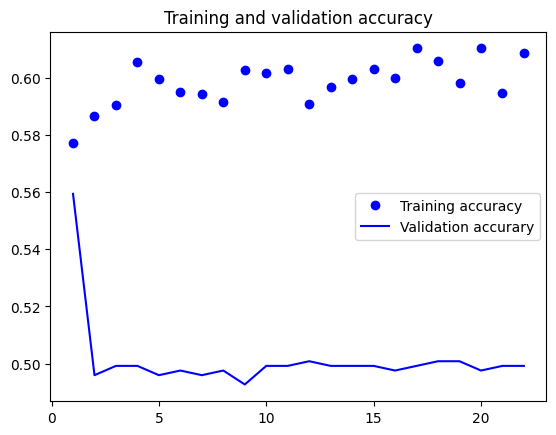

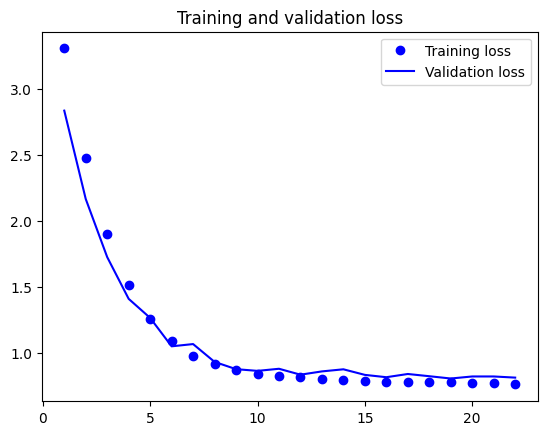

In [18]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

**Model 2**

In [6]:
model_resnet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_2.add(resnet_base)

# Add personalized layers
model_resnet_2.add(layers.GlobalAveragePooling2D())
model_resnet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_2.add(layers.Dense(1, activation='sigmoid'))

model_resnet_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

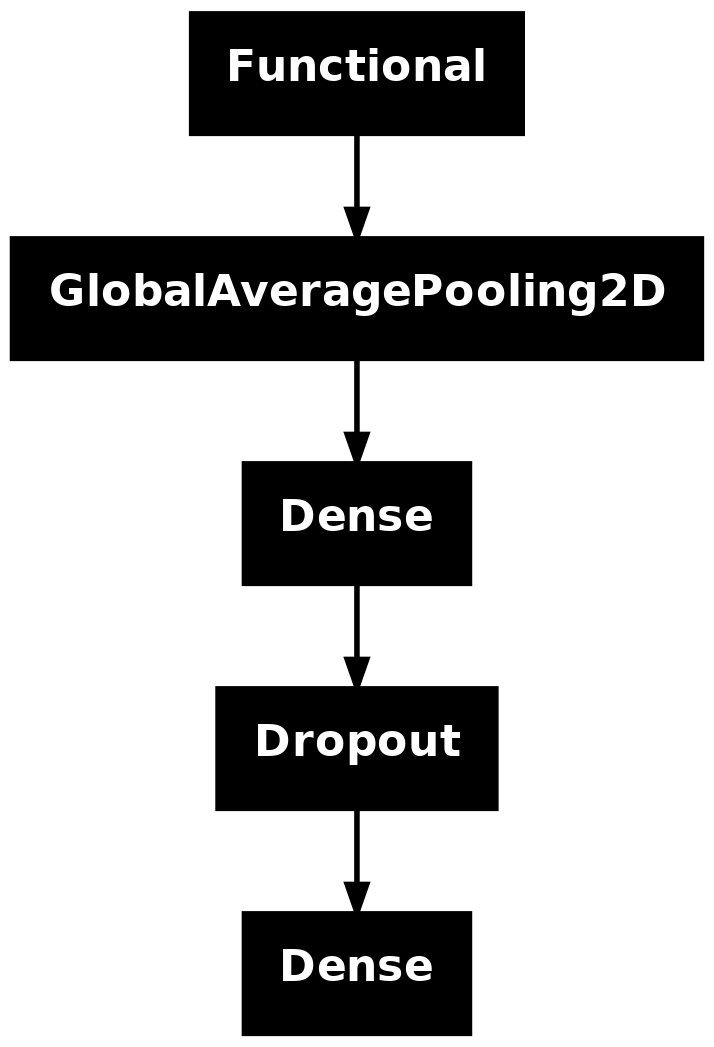

In [38]:
tf.keras.utils.plot_model(model_resnet_2)

In [7]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.2681744749596122), 1: np.float64(0.825446898002103)}


In [49]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = model_resnet_2.fit(
    train_generator,
    #steps_per_epoch = 130, #numer of imagen in each epoch
    epochs = 100,                
    validation_data = val_generator,
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weights  
)

Epoch 1/100


2024-11-21 15:21:15.781332: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.21568629, 0.21568629, 0.21568629],
         [0.21568629, 0.21568629, 0.21568629],
         [0.21443634, 0.21443634, 0.21443634],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.2141458 , 0.2141458 , 0.2141458 ],
         [0.21394606, 0.21394606, 0.21394606],
         [0.21321066, 0.21321066, 0.21321066],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21

InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.21568629, 0.21568629, 0.21568629],
         [0.21568629, 0.21568629, 0.21568629],
         [0.21443634, 0.21443634, 0.21443634],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.2141458 , 0.2141458 , 0.2141458 ],
         [0.21394606, 0.21394606, 0.21394606],
         [0.21321066, 0.21321066, 0.21321066],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        [[0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21176472],
         [0.21176472, 0.21176472, 0.21176472],
         ...,
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159],
         [0.20392159, 0.20392159, 0.20392159]],

        ...,

        [[0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         ...,
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315]],

        [[0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         ...,
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315]],

        [[0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         [0.22352943, 0.22352943, 0.22352943],
         ...,
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315],
         [0.20784315, 0.20784315, 0.20784315]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.4940495 , 0.4940495 , 0.4940495 ],
         [0.51219785, 0.51219785, 0.51219785],
         [0.5246377 , 0.5246377 , 0.5246377 ],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.49394527, 0.49394527, 0.49394527],
         [0.5121144 , 0.5121144 , 0.5121144 ],
         [0.5246794 , 0.5246794 , 0.5246794 ],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.49384108, 0.49384108, 0.49384108],
         [0.5120311 , 0.5120311 , 0.5120311 ],
         [0.5247211 , 0.5247211 , 0.5247211 ],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        ...,

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.04731702, 0.04731702, 0.04731702],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.04733787, 0.04733787, 0.04733787],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.04735871, 0.04735871, 0.04735871],
         ...,
         [0.10379671, 0.10379671, 0.10379671],
         [0.10381525, 0.10381525, 0.10381525],
         [0.10383379, 0.10383379, 0.10383379]]],


       ...,


       [[[0.19445938, 0.19445938, 0.19445938],
         [0.19432785, 0.19432785, 0.19432785],
         [0.1941963 , 0.1941963 , 0.1941963 ],
         ...,
         [0.19539481, 0.19539481, 0.19539481],
         [0.19544718, 0.19544718, 0.19544718],
         [0.18349212, 0.18349212, 0.18349212]],

        [[0.19091867, 0.19091867, 0.19091867],
         [0.19078712, 0.19078712, 0.19078712],
         [0.19065559, 0.19065559, 0.19065559],
         ...,
         [0.18759906, 0.18759906, 0.18759906],
         [0.19294576, 0.19294576, 0.19294576],
         [0.17855167, 0.17855167, 0.17855167]],

        [[0.18995   , 0.18995   , 0.18995   ],
         [0.19021307, 0.19021307, 0.19021307],
         [0.19047615, 0.19047615, 0.19047615],
         ...,
         [0.18692468, 0.18692468, 0.18692468],
         [0.19187087, 0.19187087, 0.19187087],
         [0.18002114, 0.18002114, 0.18002114]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0 [Op:__inference_one_step_on_iterator_361121]

    , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.  

2024-11-21 15:21:16.542551: W tensorflow/core/framework/op_kernel.cc:1829] INVALID_ARGUMENT: TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000

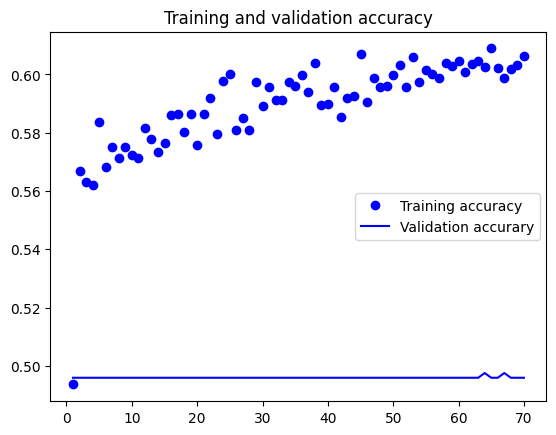

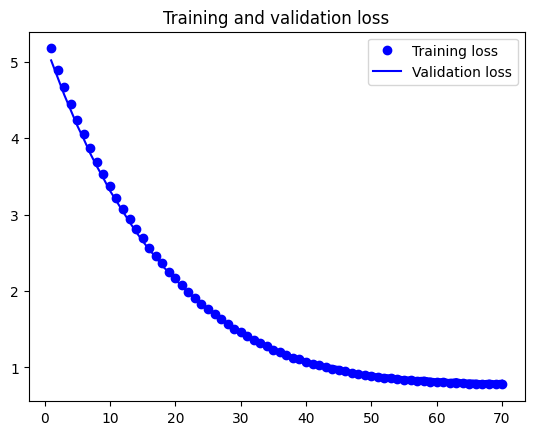

In [41]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Defuning the epochs of the model (from 1 to len(train_acc) + 1)
epochs = range(1, len(train_acc)+1)

#Creating the accuracy plot
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accurary')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
# Creating the loss plot
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# mostramos gráfico
plt.show()

In [30]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
print("Primeras 10 etiquetas:", y_batch[:10])

x_batch shape: (20, 224, 224, 3), y_batch shape: (20,)
Primeras 10 etiquetas: [0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]


#train_dir = "../1-Data/ml-dp/train"
loader = LoadImage(train_dir)

images_train = loader.images
names_train = loader.names

print(f"Number of images: {len(images_train)}") 
loader.plot_images_with_bboxes() 

loader = LoadImage(image_path='/ruta/a/imagenes', label_path='/ruta/a/labels')

#Train
preprocessor_train = PreprocessImage(images_train) 
resized_images_train, _ = preprocessor_train.resize_images_and_labels() #_ indicates that we don't have labels

resized_preprocessor_train = PreprocessImage(resized_images_train)
gray_images_train = resized_preprocessor_train.convert_to_grayscale()

normalized_preprocessor_train = PreprocessImage(gray_images_train)
normalized_images_train = normalized_preprocessor_train.normalize_images()

preprocessor = PreprocessImage(images, labels)
resized_images, labels = preprocessor.resize_images_and_labels()

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8738688811632515416
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5023793152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15785505328702574195
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


I0000 00:00:1731935039.155847  645814 gpu_device.cc:2022] Created device /device:GPU:0 with 4791 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [20]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
images, labels = next(train_generator)
print(type(labels))  # Debe ser numpy array
print(labels[:5])

<class 'numpy.ndarray'>
[1. 0. 0. 1. 1.]


### **CLAHE (Contrast Limited Adaptive Histogram Equalization)** para mejorar la calidad de las imágenes de rayos X